<a href="https://colab.research.google.com/github/Mitochondrion3000/self_project_variant_calling/blob/main/vcf_analisys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install cyvcf2


In [ ]:
from cyvcf2 import VCF
from collections import Counter

vcf = VCF("/content/synthetic_challenge_set3_tumor_20pctmasked_truth_NGv3.vcf")

# Счётчики
variant_types = Counter()
transitions = 0
transversions = 0
total_variants = 0
depths = []
qual_scores = []
heterozygous = 0
homozygous = 0

def is_transition(ref, alt):
    return (ref, alt) in {('A', 'G'), ('G', 'A'), ('C', 'T'), ('T', 'C')}

for var in vcf:
    total_variants += 1

    # Тип варианта
    if len(var.REF) == 1 and all(len(a) == 1 for a in var.ALT):
        variant_types['SNP'] += 1
        for alt in var.ALT:
            if is_transition(var.REF, alt):
                transitions += 1
            else:
                transversions += 1
    else:
        variant_types['INDEL'] += 1

    # Качество
    qual_scores.append(var.QUAL)

    # Покрытие
    if 'DP' in var.FORMAT:
        dp = var.format('DP')
        if dp is not None:
            depths.extend(dp.flatten().tolist())

    # Гено-тип (0/1 гетеро, 1/1 гомо и т.п.)
    if 'GT' in var.FORMAT:
        gt = var.genotypes[0][:2]  # только первый сэмпл
        if gt[0] != gt[1]:
            heterozygous += 1
        elif gt[0] == gt[1]:
            homozygous += 1

# Вывод результатов
print(f"Всего вариантов: {total_variants}")
print(f"  SNPs: {variant_types['SNP']}")
print(f"  INDELs: {variant_types['INDEL']}")
print(f"  Ti/Tv: {transitions / transversions:.2f}" if transversions > 0 else "Ti/Tv: inf")
print(f"  Среднее качество: {sum(qual_scores) / len(qual_scores):.2f}")
# print(f"  Средняя глубина: {sum(depths) / len(depths):.2f}")
print(f"  Гетерозиготных: {heterozygous}, Гомозиготных: {homozygous}")


Всего вариантов: 938
  SNPs: 474
  INDELs: 464
  Ti/Tv: 0.51
  Среднее качество: 100.00
  Гетерозиготных: 938, Гомозиготных: 0


выше вывел неоторые статистики а про некоторые еще предстоит узнать
| Name | Platform | Sample  | Link                                       | Number of SNVs | Number of indels | Coverage | Duplication rate (%) | Contamination | Error rate |
|------|----------|---------|--------------------------------------------|----------------|------------------|----------|-----------------------|---------------|------------|
| NGV3 | In silico| HCC1143 | [bcbio-nextgen](https://github.com/bcbio/bcbio-nextgen) | 474            | 464              | 40x      | 4.85                  | 1.08E−03      | 2.17E−04   |

In [151]:
import cyvcf2
import pandas as pd

def load_vcf(vcf_path):
    variants = []
    for variant in cyvcf2.VCF(vcf_path):
        variants.append({
            "CHROM": variant.CHROM,
            "POS": variant.POS,
            "REF": variant.REF,
            "ALT": variant.ALT[0],
            "ID": f"{variant.CHROM}:{variant.POS}:{variant.REF}>{variant.ALT[0]}",
            "FILTER": variant.FILTER,
            "INFO": variant.INFO.get("VAF", 1.0)  # Пример извлечения VAF
        })
    return pd.DataFrame(variants)

base_snp = load_vcf("/content/synthetic_challenge_set3_tumor_20pctmasked_truth_NGv3.vcf")
test_Mutect2_filtered = load_vcf("/content/filtered.vcf")
test_Mutect2_filtered_pass = test_Mutect2_filtered[test_Mutect2_filtered['FILTER'].isnull()]
test_LoFreq = load_vcf("/content/merged_LoFreq_final.vcf")


In [152]:
base_snp

,CHROM,POS,REF,ALT,ID,FILTER,INFO
0,1,1259680,G,A,1:1259680:G>A,None,0.323529
1,1,1261932,ACCTGCTGCAGACAGCGGGGCCTAGTGGTCT,A,1:1261932:ACCTGCTGCAGACAGCGGGGCCTAGTGGTCT>A,None,1.000000
2,1,1653111,CCTCCTCAAGGGAATCCCGCTT,C,1:1653111:CCTCCTCAAGGGAATCCCGCTT>C,None,1.000000
3,1,6111389,AGAATCTC,A,1:6111389:AGAATCTC>A,None,1.000000
4,1,6209539,G,GTATTCTAGCACCCTAACGAGGTA,1:6209539:G>GTATTCTAGCACCCTAACGAGGTA,None,1.000000
...,...,...,...,...,...,...,...
933,X,147582880,A,G,X:147582880:A>G,None,0.315789
934,X,147985935,T,A,X:147985935:T>A,None,0.172414
935,X,152244931,G,GAATT,X:152244931:G>GAATT,None,1.000000
936,X,153170270,T,A,X:153170270:T>A,None,0.307692


In [153]:
test_snp_Mutect2

,CHROM,POS,REF,ALT,ID,FILTER,INFO
0,chr1,16206,T,A,chr1:16206:T>A,None,1.0
1,chr1,137221,T,G,chr1:137221:T>G,None,1.0
2,chr1,566130,C,T,chr1:566130:C>T,None,1.0
3,chr1,567975,A,G,chr1:567975:A>G,None,1.0
4,chr1,905522,G,T,chr1:905522:G>T,None,1.0
...,...,...,...,...,...,...,...
12290,chr21,47674294,A,C,chr21:47674294:A>C,None,1.0
12291,chr21,47768703,A,AT,chr21:47768703:A>AT,None,1.0
12292,chr21,47831434,C,A,chr21:47831434:C>A,None,1.0
12293,chr21,47858379,C,A,chr21:47858379:C>A,None,1.0


In [154]:
test_Mutect2_filtered.head(30)

,CHROM,POS,REF,ALT,ID,FILTER,INFO
0,chr1,16206,T,A,chr1:16206:T>A,map_qual;normal_artifact;strand_bias,1.0
1,chr1,137221,T,G,chr1:137221:T>G,normal_artifact;strand_bias,1.0
2,chr1,566130,C,T,chr1:566130:C>T,map_qual;normal_artifact;weak_evidence,1.0
3,chr1,567975,A,G,chr1:567975:A>G,map_qual;normal_artifact,1.0
4,chr1,905522,G,T,chr1:905522:G>T,strand_bias;weak_evidence,1.0
5,chr1,907631,A,C,chr1:907631:A>C,base_qual;normal_artifact;strand_bias,1.0
6,chr1,907758,A,G,chr1:907758:A>G,normal_artifact;strand_bias,1.0
7,chr1,1111477,A,G,chr1:1111477:A>G,normal_artifact,1.0
8,chr1,1229195,G,C,chr1:1229195:G>C,normal_artifact;weak_evidence,1.0
9,chr1,1259680,G,A,chr1:1259680:G>A,strand_bias,1.0


In [155]:
test_Mutect2_filtered_pass

,CHROM,POS,REF,ALT,ID,FILTER,INFO
10,chr1,1261932,ACCTGCTGCAGACAGCGGGGCCTAGTGGTCT,A,chr1:1261932:ACCTGCTGCAGACAGCGGGGCCTAGTGGTCT>A,None,1.0
17,chr1,1653111,CCTCCTCAAGGGAATCCCGCTT,C,chr1:1653111:CCTCCTCAAGGGAATCCCGCTT>C,None,1.0
30,chr1,6111389,AGAATCTC,A,chr1:6111389:AGAATCTC>A,None,1.0
33,chr1,6209539,G,GTATTCTAGCACCCTAACGAGGTA,chr1:6209539:G>GTATTCTAGCACCCTAACGAGGTA,None,1.0
37,chr1,6526192,CTTCCCG,C,chr1:6526192:CTTCCCG>C,None,1.0
...,...,...,...,...,...,...,...
12232,chr21,38441595,GTT,G,chr21:38441595:GTT>G,None,1.0
12257,chr21,44536361,AAG,A,chr21:44536361:AAG>A,None,1.0
12271,chr21,46057115,C,CATCGGGACTGCTCTAACACTTATCTCCTTAGG,chr21:46057115:C>CATCGGGACTGCTCTAACACTTATCTCCT...,None,1.0
12277,chr21,46645663,T,G,chr21:46645663:T>G,None,1.0


In [156]:
test_LoFreq

,CHROM,POS,REF,ALT,ID,FILTER,INFO
0,chr1,1259680,G,A,chr1:1259680:G>A,None,1.0
1,chr1,1261932,ACCTGCTGCAGACAGCGGGGCCTAGTGGTCT,A,chr1:1261932:ACCTGCTGCAGACAGCGGGGCCTAGTGGTCT>A,None,1.0
2,chr1,1653111,CCTCCTCAAGGGAATCCCGCTT,C,chr1:1653111:CCTCCTCAAGGGAATCCCGCTT>C,None,1.0
3,chr1,6111389,AGAATCTC,A,chr1:6111389:AGAATCTC>A,None,1.0
4,chr1,6209539,G,GTATTCTAGCACCCTAACGAGGTA,chr1:6209539:G>GTATTCTAGCACCCTAACGAGGTA,None,1.0
...,...,...,...,...,...,...,...
836,chr21,31661906,A,AGGGCTTGCGTCG,chr21:31661906:A>AGGGCTTGCGTCG,None,1.0
837,chr21,31720577,C,A,chr21:31720577:C>A,None,1.0
838,chr21,31965185,T,TCTTGA,chr21:31965185:T>TCTTGA,None,1.0
839,chr21,32185261,G,A,chr21:32185261:G>A,None,1.0


формат хромосом у нас не очень совпалает уберем chr перед хромосомой


In [157]:
# Убедимся, что колонка CHROM — строка
test_snp["CHROM"] = test_snp["CHROM"].astype(str)

# Удаляем префикс 'chr', если он есть
test_snp["CHROM"] = test_snp["CHROM"].str.replace("^chr", "", regex=True)


In [158]:
test_snp.head(2)

,CHROM,POS,REF,ALT,ID,FILTER,INFO
0,1,16206,T,A,chr1:16206:T>A,None,1.0
1,1,137221,T,G,chr1:137221:T>G,None,1.0


In [159]:
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score

# Приведение CHROM к строковому типу — важно для корректного сравнения
true_positions = set(zip(base_snp["CHROM"].astype(str), base_snp["POS"]))
predicted_positions = set(zip(test_snp["CHROM"].astype(str), test_snp["POS"]))

# Полный список всех уникальных позиций из обоих источников
all_positions = sorted(true_positions.union(predicted_positions), key=lambda x: (x[0], x[1]))

# Бинарные метки: 1 — есть в наборе, 0 — нет
true_labels = [1 if position in true_positions else 0 for position in all_positions]
predicted_labels = [1 if position in predicted_positions else 0 for position in all_positions]

# Создание сводного датафрейма (необязательно, но удобно для отладки)
evaluation_df = pd.DataFrame(all_positions, columns=["CHROM", "POS"])
evaluation_df["true_label"] = true_labels
evaluation_df["predicted_label"] = predicted_labels

# Подсчёт метрик
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")


Precision: 0.073
Recall: 0.953
F1-score: 0.135


In [160]:
def calculate_metrics(truth_df, test_df):
    all_ids = pd.Index(truth_df["POS"]).union(test_df["POS"])
    y_true = all_ids.isin(truth_df["POS"]).astype(int)
    y_pred = all_ids.isin(test_df["POS"]).astype(int)
    return {
        "TPR": recall_score(y_true, y_pred),
        "PPV": precision_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred)
    }

calculate_metrics(base_snp, test_Mutect2_filtered)

{'TPR': 0.9530916844349681,
 'PPV': 0.07271248474989833,
 'F1': 0.13511675357061892}

In [161]:
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_metrics(truth_df, test_df, tool_name):
    # Создаем общий набор всех позиций (для учета FP)
    all_positions = set(truth_df["POS"]).union(set(test_df["POS"]))

    # Бинарные вектора: 1 = вариант есть в truth, 0 = нет
    y_true = [1 if pos in truth_df["POS"].values else 0 for pos in all_positions]
    y_pred = [1 if pos in test_df["POS"].values else 0 for pos in all_positions]

    return {
        "Tools": tool_name,
        "TPR": recall_score(y_true, y_pred),
        "PPV": precision_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0)
    }

In [162]:
# Список инструментов и их данных
tools = {
    "Mutect2": test_Mutect2_filtered,
    "Mutect2_filtered": test_Mutect2_filtered_pass,
    "Lofreq": test_LoFreq
}

# Расчет метрик
results = []
for name, df in tools.items():
    results.append(calculate_metrics(base_snp, df, name))

# Создание DataFrame
results_df = pd.DataFrame(results)
print(results_df)

              Tools       TPR       PPV        F1
0           Mutect2  0.953092  0.072718  0.135127
1  Mutect2_filtered  0.913646  0.787684  0.846002
2            Lofreq  0.812367  0.906064  0.856661


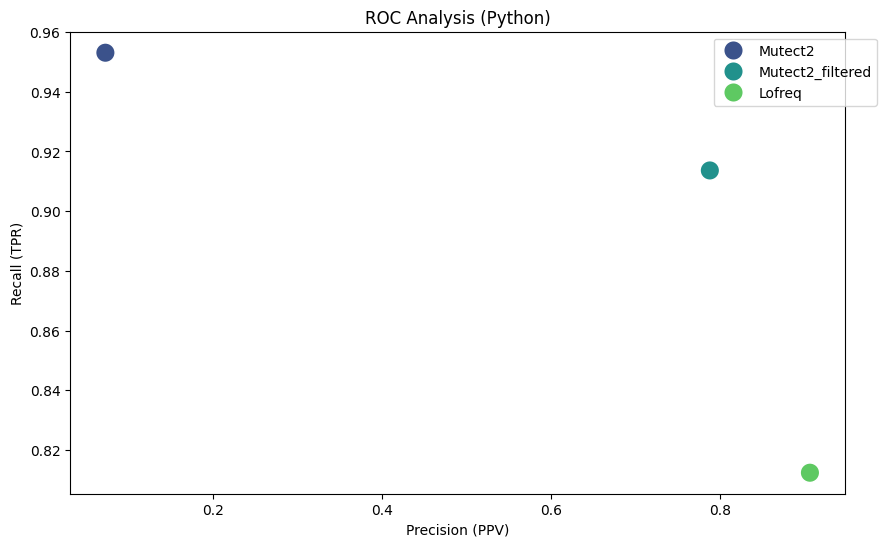

In [163]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=results_df,
    x="PPV",
    y="TPR",
    hue="Tools",
    s=200,
    palette="viridis"
)
plt.title("ROC Analysis (Python)")
plt.xlabel("Precision (PPV)")
plt.ylabel("Recall (TPR)")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

Дальше проанализируем snp отдельно, а vcf отдельно


In [164]:

def split_snp_indel(df):
    """
    Разделяет датафрейм на SNP и INDEL по длине REF и ALT.
    Ожидает наличие столбцов 'REF' и 'ALT'.

    Аргументы:
        df (pd.DataFrame): исходный датафрейм

    Возвращает:
        tuple: (df_snp, df_indel)
    """
    df_snp = df[(df['REF'].str.len() == 1) & (df['ALT'].str.len() == 1)].copy()
    df_indel = df[(df['REF'].str.len() != 1) | (df['ALT'].str.len() != 1)].copy()
    return df_snp, df_indel

# Пример использования:
# df_snp, df_indel = split_snp_indel(df)


In [165]:

test_Mutect2_filtered_pass_snp, test_Mutect2_filtered_pass_indel = split_snp_indel(test_Mutect2_filtered_pass)
test_LoFreq_snp, test_LoFreq_indel = split_snp_indel(test_LoFreq)

In [166]:
# Список инструментов и их данных

tools = {
    "Mutect2_filtered_snp": test_Mutect2_filtered_pass_snp,
    "Mutect2_filtered_indel": test_Mutect2_filtered_pass_indel,
    "LoFreq_snp": test_LoFreq_snp,
    "LoFreq_indel": test_LoFreq_indel
}


# Расчет метрик
results = []
for name, df in tools.items():
    results.append(calculate_metrics(base_snp, df, name))

# Создание DataFrame
results_vcf_indel = pd.DataFrame(results)
print(results_df)

              Tools       TPR       PPV        F1
0           Mutect2  0.953092  0.072718  0.135127
1  Mutect2_filtered  0.913646  0.787684  0.846002
2            Lofreq  0.812367  0.906064  0.856661


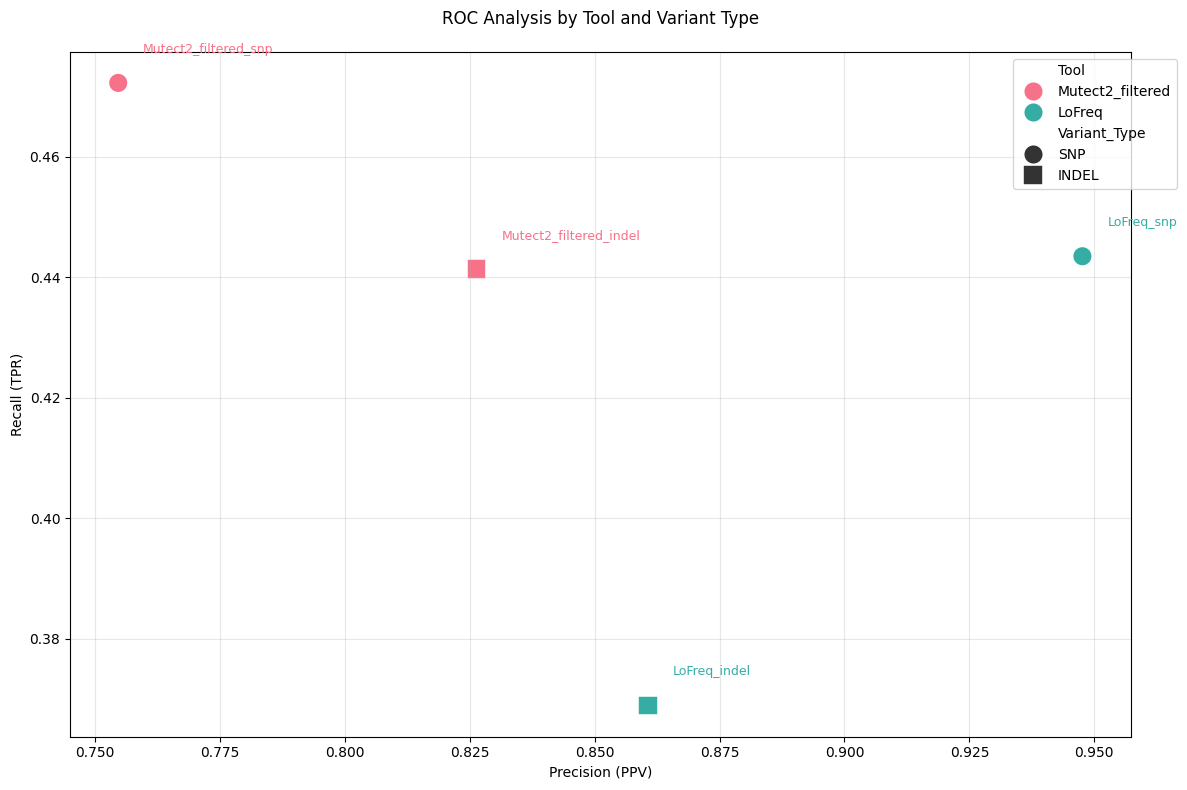

In [167]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Добавляем столбцы для инструмента и типа варианта
results_vcf_indel['Tool'] = results_vcf_indel['Tools'].str.replace('_snp|_indel', '', regex=True)
results_vcf_indel['Variant_Type'] = np.where(results_vcf_indel['Tools'].str.contains('snp'), 'SNP', 'INDEL')

# Создаем уникальную палитру для инструментов
tools = results_vcf_indel['Tool'].unique()
palette = sns.color_palette("husl", len(tools))
tool_colors = dict(zip(tools, palette))

plt.figure(figsize=(12, 8))
ax = sns.scatterplot(
    data=results_vcf_indel,
    x="PPV",
    y="TPR",
    hue="Tool",
    style="Variant_Type",
    s=200,
    palette=tool_colors,
    markers={'SNP': 'o', 'INDEL': 's'}
)

# Добавляем подписи с отступами
for _, row in results_vcf_indel.iterrows():
    ax.text(
        row['PPV'] + 0.005,
        row['TPR'] + 0.005,
        row['Tools'],
        horizontalalignment='left',
        size=9,
        color=tool_colors[row['Tool']]
    )

plt.title("ROC Analysis by Tool and Variant Type", pad=20)
plt.xlabel("Precision (PPV)")
plt.ylabel("Recall (TPR)")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()